# Pitchfork Data Analysis
Analysis of data from Pitchfork, an online music magazine hosting reviews of songs spanning multiple genres. There are over 18,000 reviews for songs from 1959 to 2017. This analysis was inspired by the following questions:
1. How have artist and genre reviews changed over time? 
2. Is there any favoritism towards certain record labels?
3. What factors are most important when determining whether a song gets "best new music"?

## Preliminaries
We begin with downloading relevant packages and connecting to the SQL database harboring the different tables.

In [1]:
# Downloading relevant packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [16]:
# Connecting to sql database using sqlite3
con = sqlite3.connect("database.sqlite")
# Creating cursor to point to tables within the database
cur = con.cursor()

## Exploration
We now move on to explore the data more closely, creating Pandas DataFrames from the SQL database whenever necessary.

In [132]:
# Let's begin by looking at artists, genre, release and review dates, and scores
# Goal for query is to only include title with release years,
# and if genre is unlisted, replace with "other"
pitchfork_sql = cur.execute(
    """
    SELECT R.reviewid AS review_id, title, artist, 
           CASE
                WHEN GY.genre IS NULL THEN "other"
                ELSE GY.genre
           END AS genre, GY.release_year, 
           pub_date AS review_date, best_new_music, score
    FROM reviews R
    LEFT JOIN (
        SELECT G.reviewid, G.genre, Y.year as release_year 
        FROM genres G
        LEFT JOIN years Y 
        ON G.reviewid = Y.reviewid
    ) AS GY 
    ON R.reviewid = GY.reviewid
    WHERE release_year IS NOT NULL
    ORDER BY release_year ASC
    """
)
# Transform queried table to pandas dataframe
pitchfork_df = pd.DataFrame(
    data = genre_artists_sql.fetchall(),
    columns = ["review_id", "title", "artist", "genre", "release_year", "review_date", "best_new_music", "score"]
)
# Looking at top rows
pitchfork_df.head()

,review_id,title,artist,genre,release_year,review_date,best_new_music,score
0,13258,drums of passion,babatunde olatunji,global,1959,2009-07-13,1,8.2
1,21797,at last!,etta james,jazz,1960,2016-04-25,0,9.0
2,17864,i hear a new world,joe meek,other,1960,2013-04-05,0,8.3
3,1544,this is our music,ornette coleman,jazz,1960,2002-03-25,0,9.4
4,22525,folk time,hart valley drifters,folk/country,1962,2016-11-15,0,7.8


In [133]:
# Changing review_date to datatimes
pitchfork_df["review_date"] = pd.to_datetime(pitchfork_df["review_date"])
# Looking at variable information
pitchfork_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23069 entries, 0 to 23068
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review_id       23069 non-null  int64         
 1   title           23069 non-null  object        
 2   artist          23069 non-null  object        
 3   genre           23069 non-null  object        
 4   release_year    23069 non-null  int64         
 5   review_date     23069 non-null  datetime64[ns]
 6   best_new_music  23069 non-null  int64         
 7   score           23069 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.4+ MB


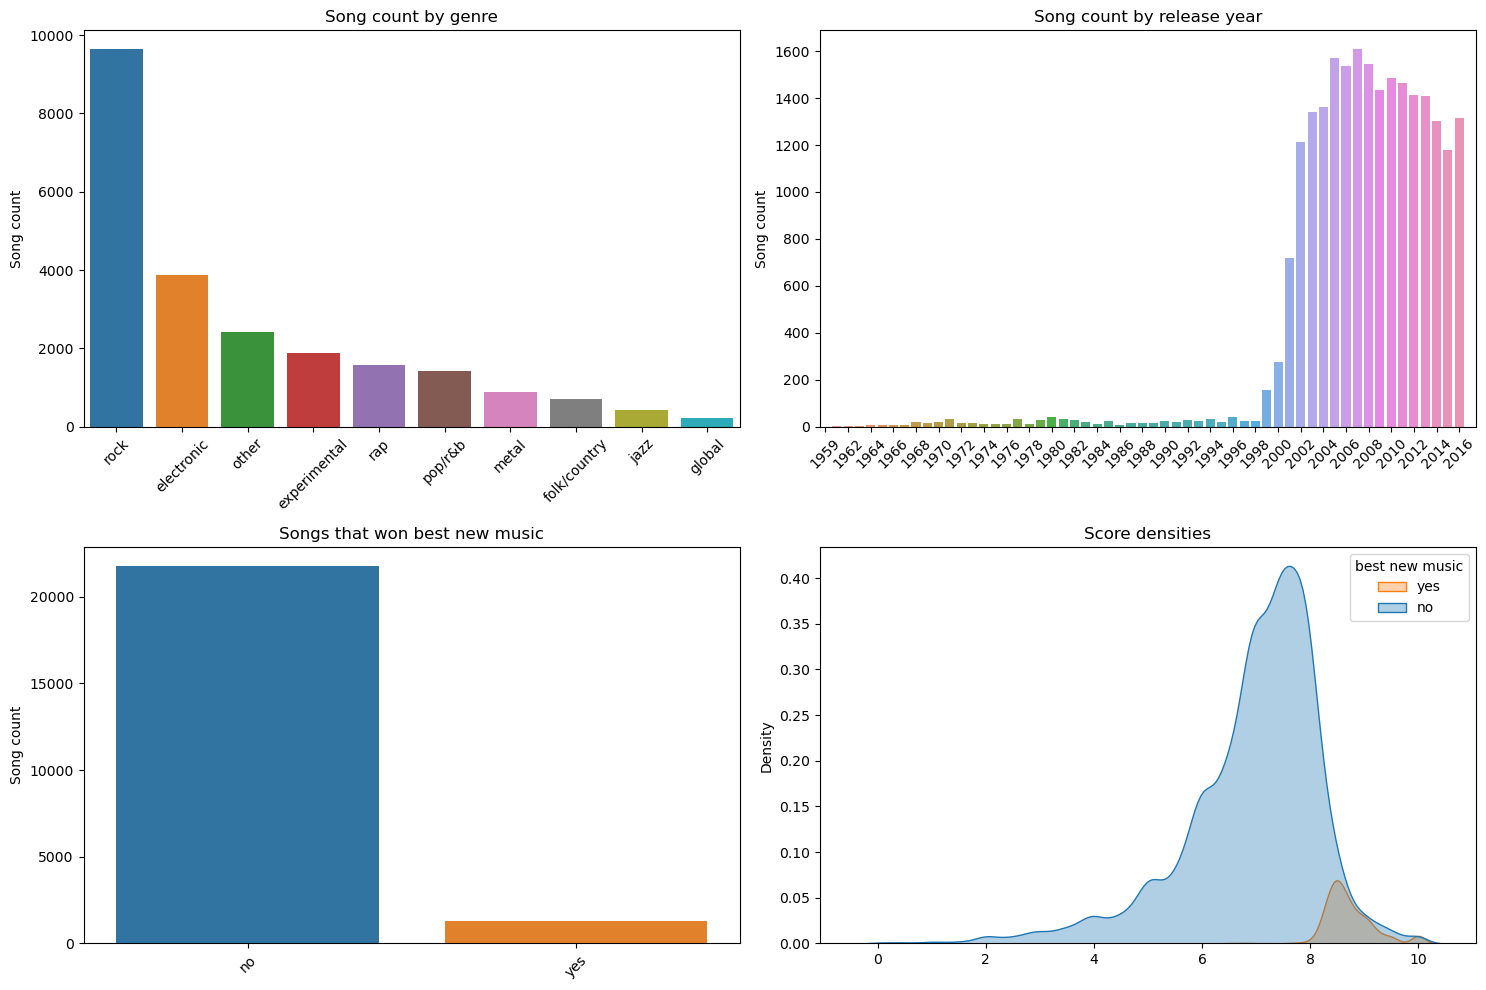

In [197]:
# Looking at barplots of songs per categories
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
# Beginning with songs by genre, sorted in descending order
genres_sorted = pitchfork_df.groupby("genre").count().rename(columns = {"score": "Song count"})["Song count"].sort_values(ascending = False)
genres_sorted_categories = genres_sorted.index
sns.barplot(
    data = pitchfork_df, 
    x = genres_sorted_categories, 
    y = genres_sorted,
    ax = ax0
)
ax0.set_xticklabels(genres_sorted_categories, rotation = 45)
ax0.set_xlabel("")
ax0.set_title("Song count by genre")
# Continuing with songs by release year, sorted by chronological order 
years_sorted = pitchfork_df.groupby("release_year").count().rename(columns = {"score": "Song count"})["Song count"]
years_sorted_categories = years_sorted.index
sns.barplot(
    data = pitchfork_df, 
    x = years_sorted_categories, 
    y = years_sorted,
    ax = ax1
)
ax1.set_xticks(np.arange(len(years_sorted))[::2])
ax1.set_xticklabels(years_sorted_categories[::2], rotation = 45)
ax1.set_xlabel("")
ax1.set_title("Song count by release year")
# Following with song count by best new music or not
bnm_sorted = pitchfork_df.groupby("best_new_music").count().rename(columns = {"score": "Song count"})["Song count"]
bnm_sorted_categories = bnm_sorted.index
sns.barplot(
    data = pitchfork_df, 
    x = bnm_sorted_categories, 
    y = bnm_sorted,
    ax = ax2
)
ax2.set_xticklabels(bnm_sorted_categories, rotation = 45)
ax2.set_xlabel("")
ax2.set_title("Songs that won best new music")
ax2.set_xticklabels(["no", "yes"])
# Finally, histogram of scores
sns.kdeplot(data = pitchfork_df,
            x = "score",
            hue = "best_new_music",
            alpha = 0.35,
            fill = True,
            ax = ax3
)
ax3.legend(["yes", "no"], title = "best new music")
ax3.set_xlabel("")
ax3.set_title("Score densities")
plt.tight_layout()
plt.show()